# PARGRAPH CLASSIFICATION -- EXPLORATION

## Clause format

The JSON file follows this structure:

- **Root Object**
  - `clauses`: an array of clause objects

- **Each Clause Object**  
  - `id` (string): a unique identifier, e.g. `"1"`  
  - `text` (string): the full text of the clause  
  - `references` (array of strings): a list of other clause IDs this clause refers to  
  - `label` (string): either `"Yes"` (AI-Related) or `"No"` (not AI-Related)

## Clause Reference Graph
Loading the `clauses.json` file—containing each clause’s text and its references—and generates a directed graph to visualize the interdependencies among the legislative clauses.

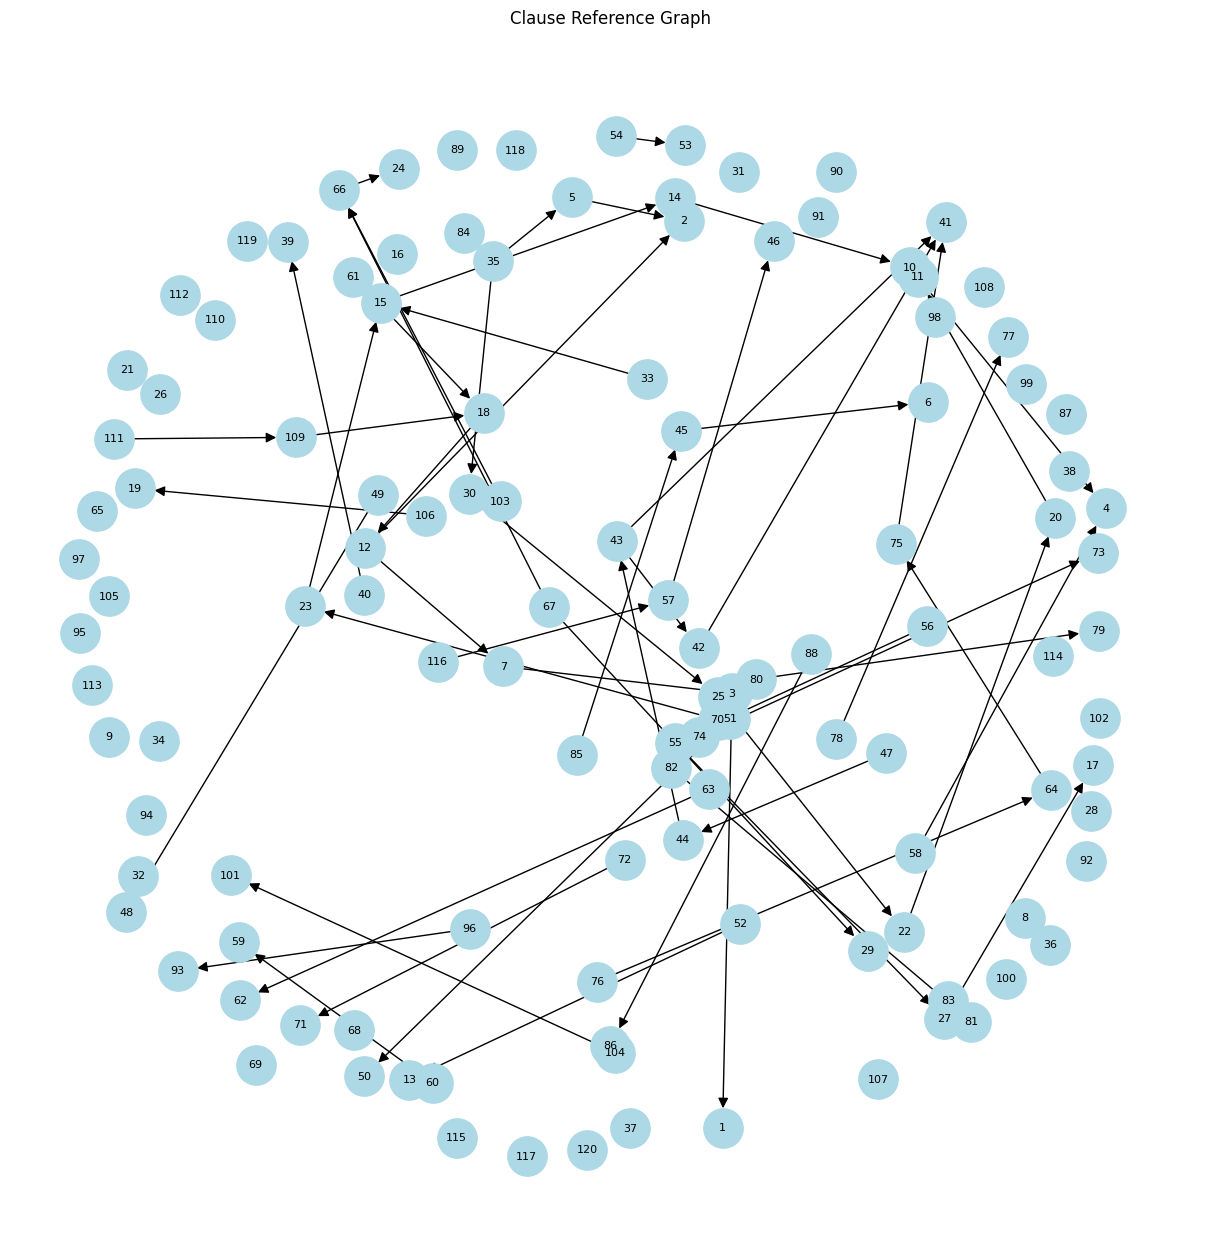

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load the clauses JSON
with open('../../data/clauses/synthetic_clauses.json', 'r') as f:
    data = json.load(f)

# Build a directed graph
G = nx.DiGraph()
for clause in data['clauses']:
    G.add_node(clause['id'])
    for ref in clause.get('references', []):
        G.add_edge(clause['id'], ref)

# Draw the graph with a spring layout
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    node_color='lightblue',
    font_size=8,
    arrowsize=15,
    arrowstyle='-|>'
)
plt.title("Clause Reference Graph")
plt.axis('off')
plt.show()


## Clause Classifcation without references

Based on those criterias:
- Any clause that directly references terms like “Artificial Intelligence,” “AI,” “machine learning,” “neural networks,” “algorithmic systems,” “cognitive systems,” or “autonomous systems” should be considered AI-related. Additionally, even if the term “AI” is not explicitly used, clauses referring to “automated decision-making,” “smart algorithms,” “intelligent systems,” “robots,” or “autonomous technologies” likely indicate that AI technology is involved.

- Clauses that mention “emerging technologies,” “innovation,” or “technological advancement”.

- Any clause that addresses automation in processes, such as “automated decision-making,” “automation of tasks,” or “intelligent automation,” could indicate a focus on AI systems.

- Clauses that focus on data collection, processing, use, or privacy.

- Clauses that address security concerns around these technologies are also relevant. (cyber-attacks.)

#### Imports :

In [ ]:
import re
import os
from typing import List
import anthropic
from sklearn.metrics import accuracy_score, f1_score, classification_report
import json
from dotenv import load_dotenv

load_dotenv(dotenv_path="../../data/contracts/confidential/secrets.env")
api_key = os.getenv("ANTHROPIC_API_KEY")
if not api_key:
    raise RuntimeError("Variable ANTHROPIC_API_KEY introuvable dans secrets.env")
client = anthropic.Anthropic(api_key=api_key)

with open('../../data/clauses/synthetic_clauses.json', 'r') as f:
        data = json.load(f)




### First Approach : Simple LLM Call



In [24]:
class SimpleLLMClassifier:
    def __init__(self):
        self.client = client

    def classify_clause(self, text):
        prompt = f"""
You are a legislation analysis expert. Your task is to decide if a legal clause is "AI-related" or "Not-AI-related".

**Definitions:**
- A clause is **AI-related** if it directly or indirectly discusses:
  - Artificial Intelligence, machine learning, neural networks, or algorithmic systems.
  - Automated decision-making, robots, or intelligent systems.
  - Emerging technologies, innovation, or technological advancement.
  - Data collection, data processing, privacy, or cybersecurity in a technological context.

**Instructions:**
- Read the **Main Clause** carefully first.
- Use the **Referenced Clauses** ONLY as context — do not automatically label based on references alone.
- If the Main Clause’s **topic or purpose** becomes AI-related because of its references, then mark "Yes".
- If the Main Clause remains unrelated to AI even after reading references, mark "No".
- Think carefully whether the references meaningfully affect the main clause's meaning.

Return exactly one word: **Yes** or **No**.

---

Main Clause:
\"\"\"{text}\"\"\"

Answer with one word only: Yes or No.
"""
        response = self.client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1,
            temperature=0.0,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text.strip()
    

if __name__ == "__main__":
    classifier = SimpleLLMClassifier()

    y_true = []
    y_pred = []

    for clause in data["clauses"]:
        text = clause["text"]
        true_label = clause["label"]
        predicted_label = classifier.classify_clause(text)

        y_true.append(true_label)
        y_pred.append(predicted_label)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")

    labels = ["Yes", "No"]
    report = classification_report(
        y_true, y_pred, labels=labels, target_names=labels, zero_division=0
    )

    # Output results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Weighted F1 Score: {weighted_f1:.2f}\n")
    print("Detailed Classification Report:")
    print(report)

Accuracy: 0.97
Weighted F1 Score: 0.97

Detailed Classification Report:
              precision    recall  f1-score   support

         Yes       1.00      0.91      0.96        35
          No       0.97      1.00      0.98        85

    accuracy                           0.97       120
   macro avg       0.98      0.96      0.97       120
weighted avg       0.98      0.97      0.97       120



### Second Approach : Orchestrator-workers

Will use the Orchestrator-workers workflow architecture :

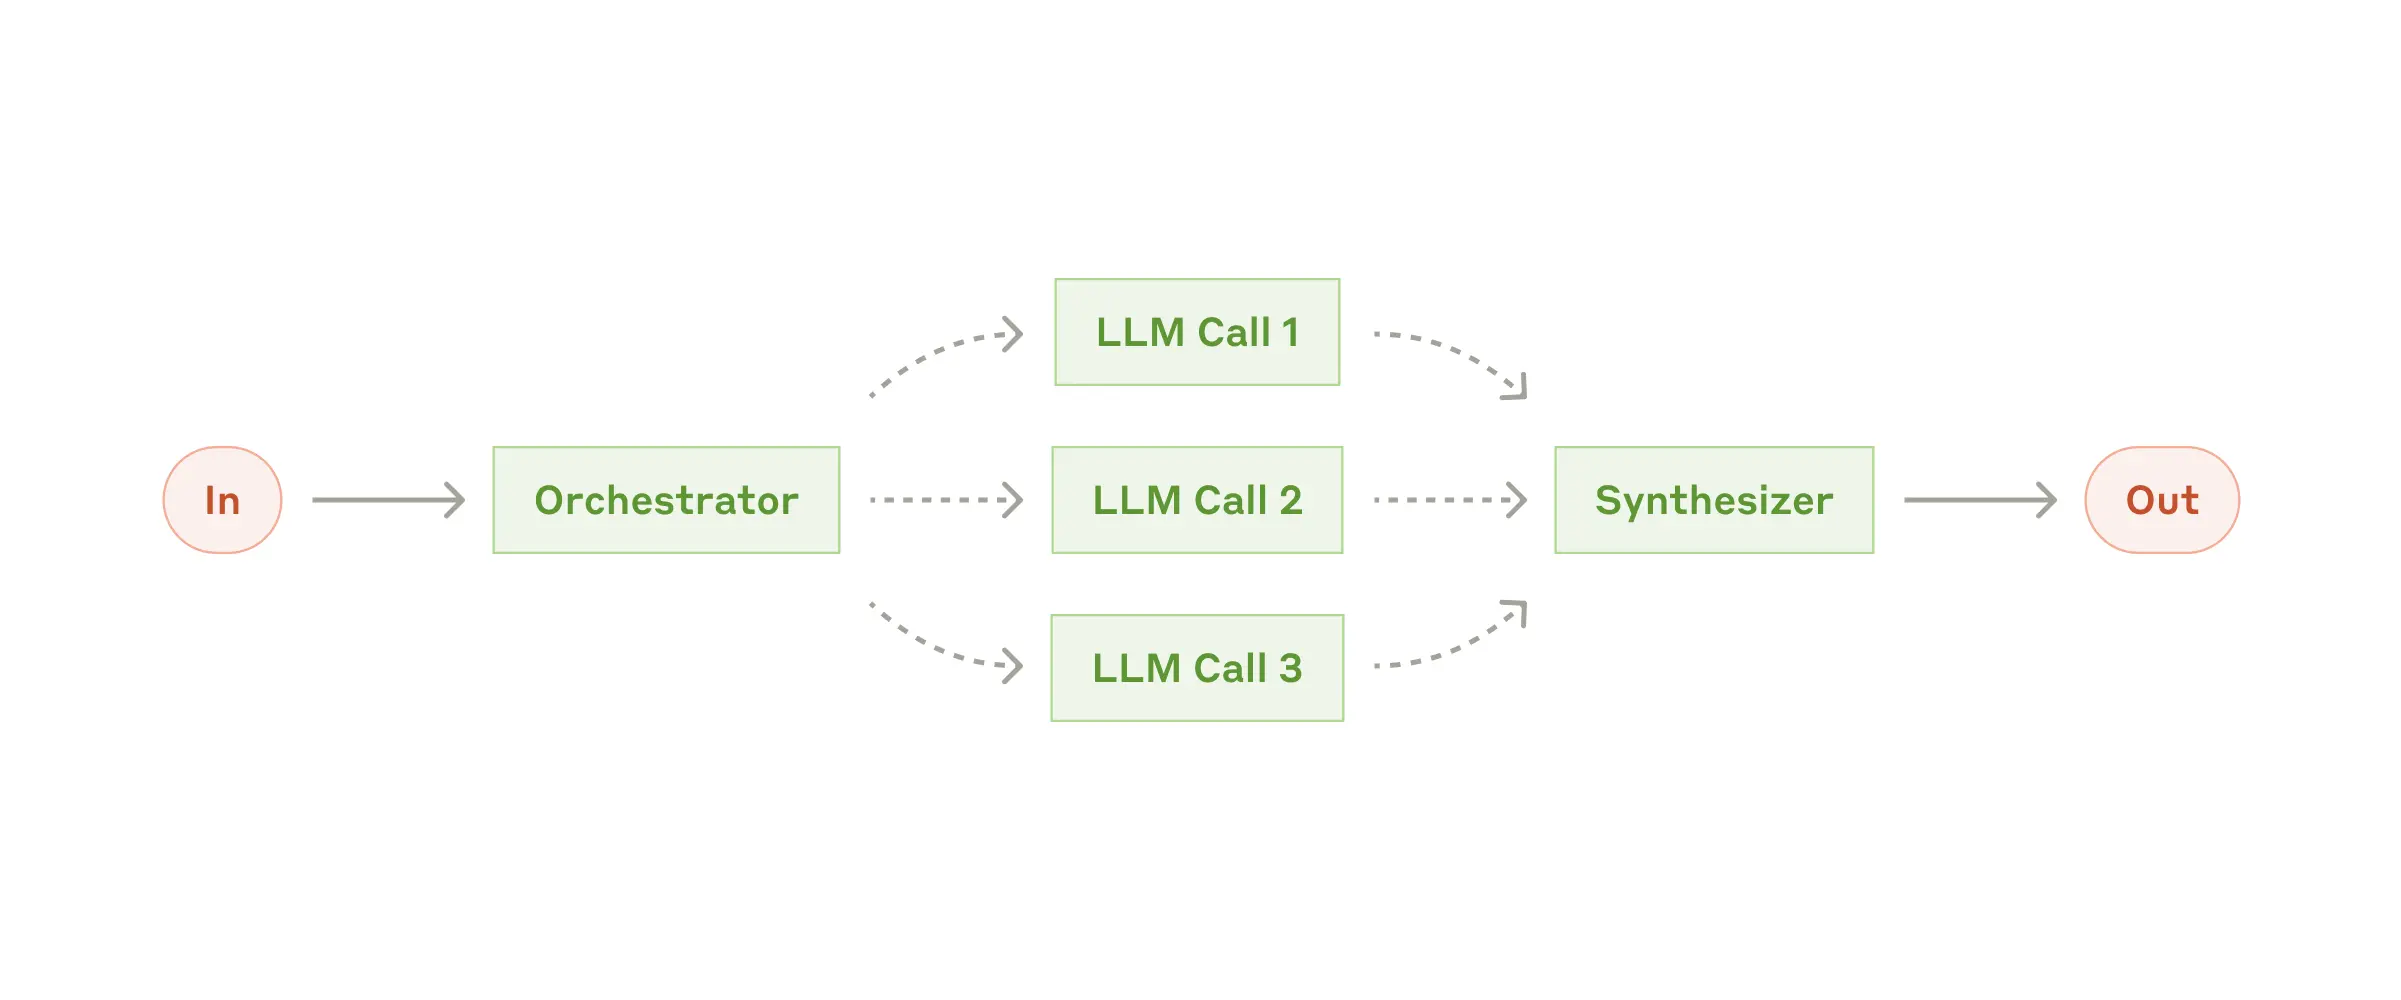
from https://www.anthropic.com/engineering/building-effective-agents

#### Claude‐based agents

In [ ]:
def llm_call(prompt):
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=1,  # Only need "Yes" or "No"
        temperature=0.0,  # Zero randomness for strict outputs
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return response.content[0].text.strip()

class DirectAIAgent:
    def classify(self, text):
        prompt = f"""
Is the following clause explicitly mentioning artificial intelligence, machine learning, neural networks, or algorithmic systems?
Clause: "{text}"

Answer with only one word: Yes or No.
"""
        return llm_call(prompt)  # Your LLM API call

class AutomationAgent:
    def classify(self, text):
        prompt = f"""
Is the following clause describing automation, automated decision-making, autonomous systems, robots, or intelligent systems?
Clause: "{text}"

Answer with only one word: Yes or No.
"""
        return llm_call(prompt)

class EmergingTechAgent:
    def classify(self, text):
        prompt = f"""
Does the following clause refer to emerging technologies, innovation, or technological advancement (even indirectly)?
Clause: "{text}"

Answer with only one word: Yes or No.
"""
        return llm_call(prompt)

class PrivacySecurityAgent:
    def classify(self, text):
        prompt = f"""
Is the following clause focused on data collection?
Is the following clause focused on data processing?
Is the following clause focused on privacy related to technology use?
Is the following clause related to cybersecurity issues?
Clause: "{text}"

If you think that this clause is related to any of the questions above, answer with only one word: Yes or No.
"""
        return llm_call(prompt)

#### Synthetizer

In [26]:
class Synthesizer:
    def synthesize(self, votes):
        if "Yes" in votes:
            return "Yes"
        return "No"

#### Orchestrator: combine agents in a pipeline

In [30]:
class Orchestrator:
    def __init__(self):
        self.agents = [
            DirectAIAgent(),
            AutomationAgent(),
            EmergingTechAgent(),
            PrivacySecurityAgent()
        ]
        self.synthesizer = Synthesizer()

    def classify_clause(self, text):
        votes = [agent.classify(text) for agent in self.agents]
        return self.synthesizer.synthesize(votes)

In [31]:
if __name__ == "__main__":

    # Initialize the orchestrator (the new multi-agent classifier)
    orchestrator = Orchestrator()

    # Collect true labels and predictions
    y_true = []
    y_pred = []

    for clause in data["clauses"]:
        text = clause["text"]
        true_label = clause["label"]
        predicted_label = orchestrator.classify_clause(text)

        y_true.append(true_label)
        y_pred.append(predicted_label)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")

    labels = ["Yes", "No"]
    report = classification_report(
        y_true, y_pred, labels=labels, target_names=labels, zero_division=0
    )

    # Output results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Weighted F1 Score: {weighted_f1:.2f}\n")
    print("Detailed Classification Report:")
    print(report)


Accuracy: 0.62
Weighted F1 Score: 0.62

Detailed Classification Report:
              precision    recall  f1-score   support

         Yes       0.43      1.00      0.60        35
          No       1.00      0.46      0.63        85

    accuracy                           0.62       120
   macro avg       0.72      0.73      0.62       120
weighted avg       0.83      0.62      0.62       120



## Clause Classifcation with references

The best one already is a simple LLM call. Only errors where when the relation to AI was indirect, through reference to other clauses.
We know will give every reference in the prompt

In [64]:
class SimpleLLMClassifierWithReferences:
    def __init__(self, clauses):
        self.client = anthropic.Anthropic()
        self.clause_lookup = {clause["id"]: clause["text"] for clause in clauses}

    def classify_clause(self, clause):
        base_text = clause["text"]
        references = clause.get("references", [])
        
        # Fetch and append referenced clauses
        referenced_texts = [
            self.clause_lookup[ref_id] for ref_id in references if ref_id in self.clause_lookup
        ]

        referenced_clauses_section = ""
        if referenced_texts:
            referenced_clauses_section = "Referenced Clauses:\n" + "\n\n".join(f'"{ref}"' for ref in referenced_texts)
        
        prompt = f"""
You are a legislation analysis expert. Your task is to decide if a legal clause is "AI-related" or "Not-AI-related".

**Definitions:**
- A clause is **AI-related** if it directly or indirectly discusses:
  - Artificial Intelligence, machine learning, neural networks, or algorithmic systems.
  - Automated decision-making, robots, or intelligent systems.
  - Emerging technologies, innovation, or technological advancement.
  - Data collection, data processing, privacy, or cybersecurity in a technological context.

**Instructions:**
- Read the **Main Clause** carefully first.
- Use the **Referenced Clauses** ONLY as context — do not automatically label based on references alone.
- If the Main Clause’s **topic or purpose** becomes AI-related because of its references, then mark "Yes".
- If the Main Clause remains unrelated to AI even after reading references, mark "No".
- Think carefully whether the references meaningfully affect the main clause's meaning.

Return exactly one word: **Yes** or **No**.

---

Main Clause:
\"\"\"{base_text}\"\"\"

{referenced_clauses_section}

---

Final Answer (Yes or No):
"""

        response = self.client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1,
            temperature=0.0,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text.strip()
    
if __name__ == "__main__":
    classifier = SimpleLLMClassifierWithReferences(clauses=data["clauses"])

    y_true = []
    y_pred = []
    misclassified = []  # <-- store misclassified examples here

    for clause in data["clauses"]:
        true_label = clause["label"]
        predicted_label = classifier.classify_clause(clause)

        y_true.append(true_label)
        y_pred.append(predicted_label)

        # Save misclassified examples
        if predicted_label != true_label:
            misclassified.append({
                "id": clause["id"],
                "text": clause["text"],
                "references": clause.get("references", []),
                "true_label": true_label,
                "predicted_label": predicted_label
            })

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")

    labels = ["Yes", "No"]
    report = classification_report(
        y_true, y_pred, labels=labels, target_names=labels, zero_division=0
    )

    # Output results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Weighted F1 Score: {weighted_f1:.2f}\n")
    print("Detailed Classification Report:")
    print(report)

    # Output misclassified clauses
    if misclassified:
        print("\n⚠️ Misclassified Clauses:\n")
        for entry in misclassified:
            print(f"Clause ID: {entry['id']}")
            print(f"True Label: {entry['true_label']} | Predicted Label: {entry['predicted_label']}")
            print(f"Text: {entry['text']}")
            if entry["references"]:
                print(f"References: {entry['references']}")
            print("-" * 80)
    else:
        print("\n✅ No misclassified clauses!")


Accuracy: 0.98
Weighted F1 Score: 0.98

Detailed Classification Report:
              precision    recall  f1-score   support

         Yes       1.00      0.94      0.97        35
          No       0.98      1.00      0.99        85

    accuracy                           0.98       120
   macro avg       0.99      0.97      0.98       120
weighted avg       0.98      0.98      0.98       120


⚠️ Misclassified Clauses:

Clause ID: 88
True Label: Yes | Predicted Label: No
Text: Employers shall calculate employee wages in compliance with applicable labor standards. Payroll records must include hours worked, rate of pay, and deductions, and be retained for at least seven years. The labor authority may audit records to verify compliance with wage laws. Discrepancies found during audits shall be remedied within forty-five days of notice.
References: ['86']
--------------------------------------------------------------------------------
Clause ID: 111
True Label: Yes | Predicted Label: No